In [49]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit of ensemble of covariance"
nb_name = "nb_midpath_dynamo_fit_covmod"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

In [3]:
print(core)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Fit of ensemble of covariance
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core_ens
grid_zero:        (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:   (31,), Max/Min: 0.10 / 0.01
grid_shape:       (2,), Max/Min: 61.00 / 31.00
grid_w:           (1891,), Max/Min: 0.10 / 0.01
grid_radial:      (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:       (1891,), Max/Min: 175.63 / 4.37
grid_phi:         (1891,), Max/Min: 354.10 / 0.00
grid_N:           1891
grid_nmax:        30
r_grid:           3480.0
grid:             (1891, 2)
sph_d:            (1891, 1891)
lon:              (1891,), Max/Min: 354.10 / 0.00
lat:              (1891,), Max/Min: 85.63 / -85.63
N_grid:           1891
m_core_ens:       (1891, 487)

<IPython.core.display.Javascript object>


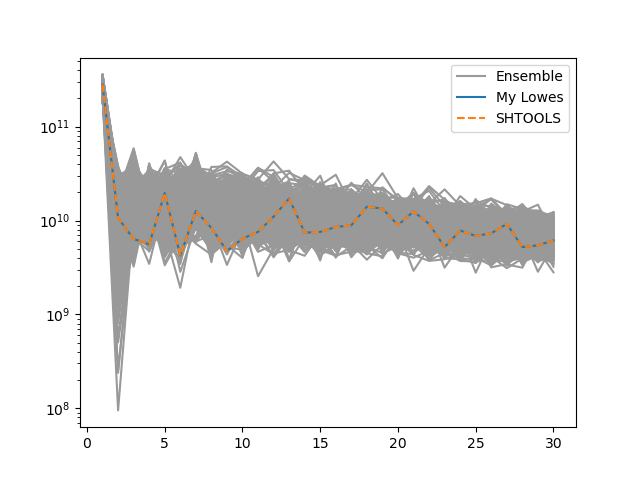

In [9]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

(1891, 1891)


<IPython.core.display.Javascript object>


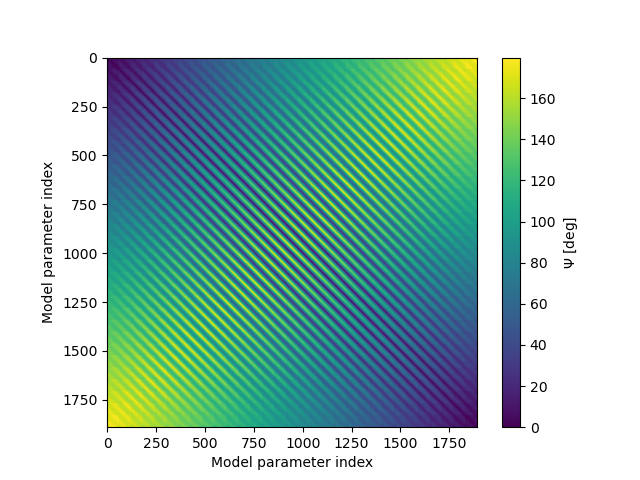

In [11]:
# Compute cos(angdist) array for model parameter sphere
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [core.grid_theta.reshape(1,-1), core.grid_theta.reshape(-1,1), 
                                      core.grid_phi.reshape(1,-1), core.grid_phi.reshape(-1,1)])

c_angdist = np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s))

c_angdist[c_angdist>1] = 1.0
print(c_angdist.shape)

plt.figure()
plt.imshow(np.arccos(c_angdist)*180/np.pi)
plt.colorbar(label="$\Psi$ [deg]")
plt.xlabel("Model parameter index")
plt.ylabel("Model parameter index")
plt.show()

In [14]:
# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_max+1)+1)/(2*np.arange(1,n_max+1)+1)

C_Br = []

for cmu in np.ravel(c_angdist):
    C_Br.append(np.sum(C_const.reshape(-1,1)*R*pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1),axis=0))
    
C_Br = np.array(C_Br).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))
if C_Br.shape[2] == 1:
    C_Br_model = C_Br[:,:,0]
else:
    C_Br_model = C_Br[:,:,core.ens_idx]

C_Br_model is pos def: False
All eigenvalues > 0: False
Number of negative eigenvalues: 592 / 1891


<IPython.core.display.Javascript object>


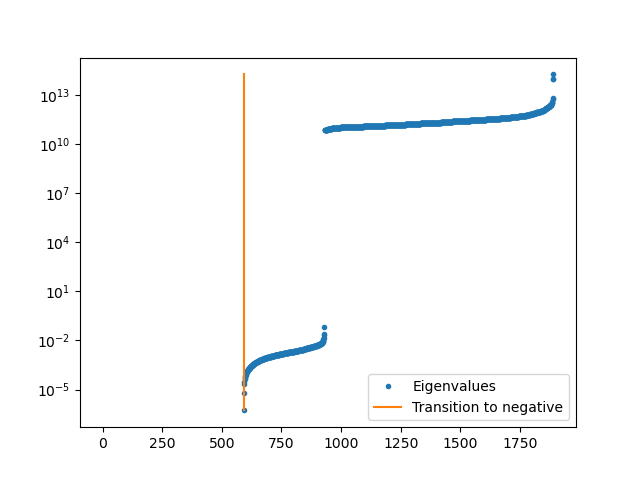

In [30]:
# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()



In [39]:
# Evenly skip every "skip" point pairs and sort according to great circle distance

skip = 5

sph_d_skip = np.ravel(core.sph_d.reshape((core.N_grid,core.N_grid))[0::skip,0::skip])
i_sph_d_skip = np.argsort(sph_d_skip)

<IPython.core.display.Javascript object>


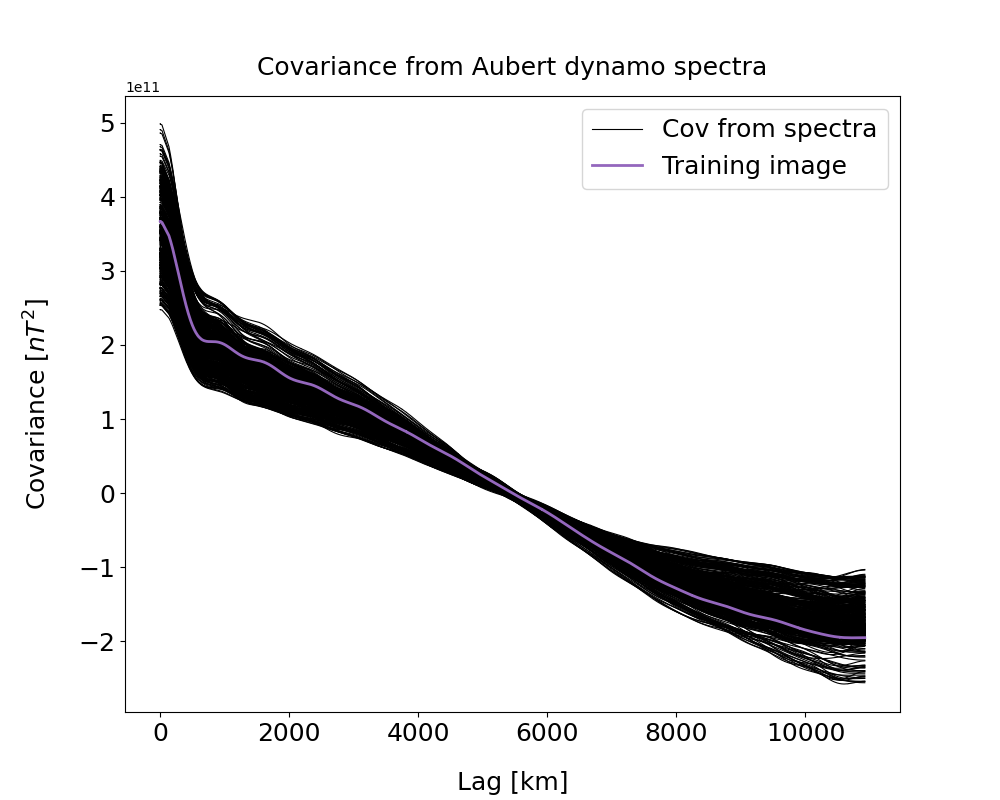

In [40]:
#%% PLOT COVARIANCE
plt.figure(figsize=(10,8)) 

for i in np.arange(0,C_Br.shape[-1]):
    if i == 0:
        plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(C_Br[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", label='Cov from spectra', zorder=0.1)
    else:
        plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(C_Br[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", zorder=0.1)

plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(C_Br[0::skip,0::skip,core.ens_idx])[i_sph_d_skip], 
         linewidth = 2.0, color="C4", label='Training image', zorder=0.2)

plt.ylabel('Covariance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Covariance from Aubert dynamo spectra",fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [ ]:
t = np.linspace(0,np.max(core.sph_d),1000)
c = 10000
a = 1
tau_cauchy = 1
tau_askey = 2
tau_c2 = 4
tau_c4 = 6
c0 = 0.0#np.max(C_Br_model)
c1 = 1.5*np.max(C_Br_model)

spherical = c0+c1*(1+1/2*t/c)*(1-t/c)**2
pexp = c0+c1*np.exp(-(t/c)**a)
gen_cauchy = c0+c1*(1+(t/c))**(-tau_cauchy/a)
askey = c0+c1*(1-t/c)**tau_askey
c2_wend = c0+c1*(1+tau_c2*t/c)*(1-t/c)**tau_c2
c4_wend = c0+c1*(1+tau_c4*t/c+(tau_c4**2-1)/3*t**2/c**2)*(1-t/c)**tau_c4

plt.figure(figsize=(10,8))
plt.plot(t,spherical,t,pexp,t,gen_cauchy,t,askey,t,c2_wend,t,c4_wend)
plt.legend(("Spherical", "Power exp", "Gen Cauchy","Askey","C2-Wendland","C4-Wendland"),loc='best',fontsize=18)
plt.ylabel('Correlation',fontsize=18,labelpad=18)
plt.xlabel('GCD [km]',fontsize=18,labelpad=18)
plt.title("Possible pos def functions",fontsize=18,y=1.02)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [244]:
# Evenly skip every "skip" point pairs and sort according to great circle distance

skip = 5

sph_d_skip = np.ravel(core.sph_d.reshape((core.N_grid,core.N_grid))[0::skip,0::skip])
i_sph_d_skip = np.argsort(sph_d_skip)

model_gcd = sph_d_skip[i_sph_d_skip]
model_cov = np.ravel(C_Br_model[0::skip,0::skip])[i_sph_d_skip]

print(model_gcd.shape)

(143641,)


In [297]:
#Spherical
def cov_return(t, c, c0, c1):
    return c0+c1*(1+1/2*t/c)*(1-t/c)**2
p0 = [10**3,0.0,np.max(C_Br_model)]
bounds = ([0,0,0],inf)
popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
cov_sph = cov_return(sph_d_skip[i_sph_d_skip], popt[0], popt[1], popt[2])
print(popt)

[9.09898420e+03 4.34859688e+04 7.15337907e+10]


In [298]:
#Power exp
def cov_return(t, c, c0, c1,a):
    return c0+c1*np.exp(-(t/c)**a)
p0 = [10**1,0.0,np.max(C_Br_model),0.5]
bounds = ([0,0,0,0.0001],[inf,inf,inf,1])
popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
cov_pexp = cov_return(sph_d_skip[i_sph_d_skip], popt[0], popt[1], popt[2], popt[3])
print(popt)

[1.77483314e+03 1.88823740e+00 4.02502894e+11 1.00000000e+00]


In [299]:
#Gen Cauchy
def cov_return(t, c, c0, c1, a, tau):
    return c0+c1*(1+(t/c))**(-tau/a)
p0 = [10**1,0.0,np.max(C_Br_model),0.5, 0.5]
bounds = ([0,0,0,0.0001, 0.0001],[inf,inf,inf,1, 1])
popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
cov_cauchy = cov_return(sph_d_skip[i_sph_d_skip], popt[0], popt[1], popt[2], popt[3], popt[4])
print(popt)

[1.12739668e+04 7.57081383e+08 3.83074990e+11 1.14920164e-01
 8.85077666e-01]


In [302]:
#Askey
def cov_return(t, c, c0, c1, tau):
    return c0+c1*(1-t/c)**tau
p0 = [10**10,0.0,np.max(C_Br_model),3]
bounds = ([0,0,0,2],[inf,inf,inf,inf])
popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
cov_ask = cov_return(sph_d_skip[i_sph_d_skip], popt[0], popt[1], popt[2], popt[3])
print(popt)

[3.53058965e+09 1.33556720e-01 4.03097635e+11 1.99229334e+06]


In [303]:
#C2-Wendland
def cov_return(t, c, c0, c1, tau):
    return c0+c1*(1+tau*t/c)*(1-t/c)**tau

p0 = [10**10,0.0,np.max(C_Br_model),6]
bounds = ([0,0,0,4],inf)
popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
cov_C2 = cov_return(sph_d_skip[i_sph_d_skip], popt[0], popt[1], popt[2], popt[3])
print(popt)

[3.19824747e+08 2.10945200e+06 4.61499699e+10 1.61058386e+05]


In [311]:
#C4-Wendland
def cov_return(t, c, c0, c1, tau):
    return c0+c1*(1+tau*t/c+(tau**2-1)/3*t**2/c**2)*(1-t/c)**tau

p0 = [10**7,0.0,np.max(C_Br_model),8]
bounds = ([0,0,0,6],inf)
popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
cov_C4 = cov_return(sph_d_skip[i_sph_d_skip], popt[0], popt[1], popt[2], popt[3])
print(popt)

<ipython-input-311-858b0a7d0f7a>:3: RuntimeWarning: invalid value encountered in power
  return c0+c1*(1+tau*t/c+(tau**2-1)/3*t**2/c**2)*(1-t/c)**tau


[4.68983408e+05 4.61922247e+01 2.73263161e+11 4.82761242e+02]


<IPython.core.display.Javascript object>


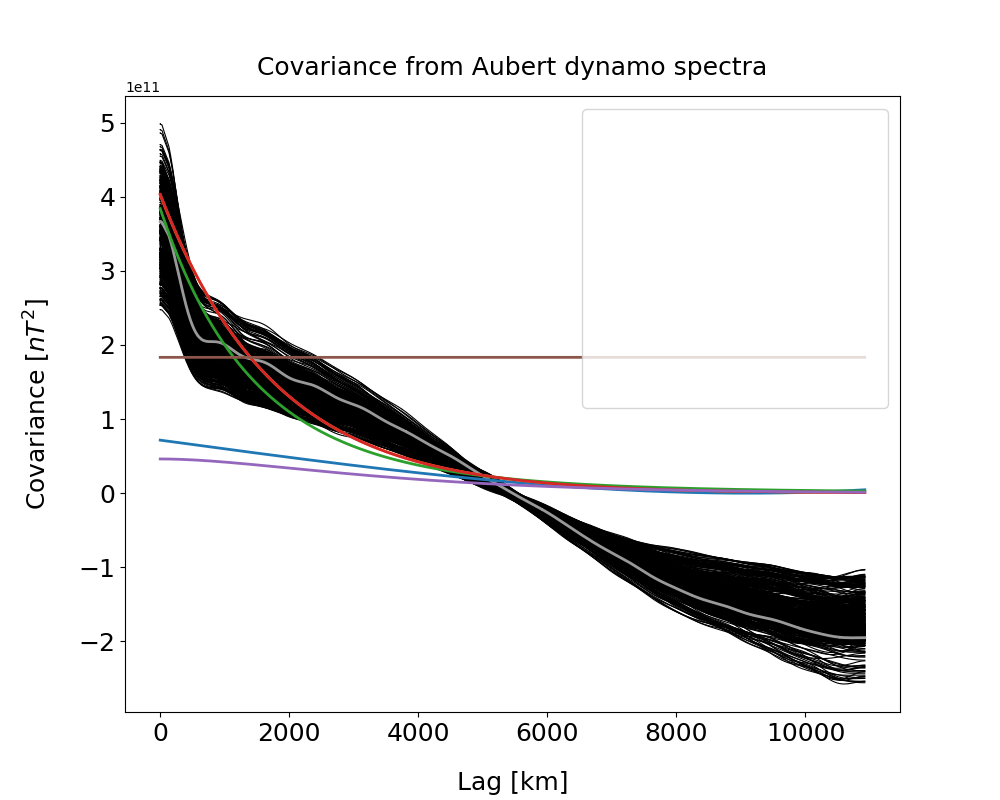

In [310]:
#%% PLOT COVARIANCE
plt.figure(figsize=(10,8)) 

for i in np.arange(0,C_Br.shape[-1]):
    if i == 0:
        plt.plot(model_gcd, np.ravel(C_Br[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", label='Cov from spectra', zorder=0.1)
    else:
        plt.plot(model_gcd, np.ravel(C_Br[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", zorder=0.1)

plt.plot(model_gcd, np.ravel(C_Br[0::skip,0::skip,core.ens_idx])[i_sph_d_skip], 
         linewidth = 2.0, color=(0.6,0.6,0.6), label='Training image', zorder=0.2)

plt.plot(model_gcd, cov_sph, 
         linewidth = 2.0, color="C0", label='Spherical', zorder=0.3)

plt.plot(model_gcd, cov_pexp, 
         linewidth = 2.0, color="C1", label='Power exp', zorder=0.3)

plt.plot(model_gcd, cov_cauchy, 
         linewidth = 2.0, color="C2", label='Gen Cauchy', zorder=0.3)

plt.plot(model_gcd, cov_ask, 
         linewidth = 2.0, color="C3", label='Askey', zorder=0.3)

plt.plot(model_gcd, cov_C2, 
         linewidth = 2.0, color="C4", label='C2-Wendland', zorder=0.3)

plt.plot(model_gcd, cov_C4, 
         linewidth = 2.0, color="C5", label='C4-Wendland', zorder=0.3)

plt.ylabel('Covariance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Covariance from Aubert dynamo spectra",fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()